# Guide to Network Analysis (Part 2 - Find Routes)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li><li><span><a href="#Problem-statement" data-toc-modified-id="Problem-statement-2">Problem statement</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3">Data</a></span><ul class="toc-item"><li><span><a href="#Access-the-Stops-Feature-Class" data-toc-modified-id="Access-the-Stops-Feature-Class-3.1">Access the Stops Feature Class</a></span></li><li><span><a href="#Re-arrange-the-order-of-stops" data-toc-modified-id="Re-arrange-the-order-of-stops-3.2">Re-arrange the order of stops</a></span></li></ul></li><li><span><a href="#Methods" data-toc-modified-id="Methods-4">Methods</a></span><ul class="toc-item"><li><span><a href="#Method-1---Using-arcgis.network.analysis.find_routes" data-toc-modified-id="Method-1---Using-arcgis.network.analysis.find_routes-4.1">Method 1 - Using arcgis.network.analysis.find_routes</a></span><ul class="toc-item"><li><span><a href="#Tabularizing-the-response-from-find_routes" data-toc-modified-id="Tabularizing-the-response-from-find_routes-4.1.1">Tabularizing the response from find_routes</a></span></li><li><span><a href="#Visualizing-the-response-from-find_routes" data-toc-modified-id="Visualizing-the-response-from-find_routes-4.1.2">Visualizing the response from find_routes</a></span></li></ul></li><li><span><a href="#Method-2---Using-arcgis.features.use_proximity.plan_routes" data-toc-modified-id="Method-2---Using-arcgis.features.use_proximity.plan_routes-4.2">Method 2 - Using arcgis.features.use_proximity.plan_routes</a></span><ul class="toc-item"><li><span><a href="#Prepare-the-input-parameters" data-toc-modified-id="Prepare-the-input-parameters-4.2.1">Prepare the input parameters</a></span></li><li><span><a href="#With-output_name-specified" data-toc-modified-id="With-output_name-specified-4.2.2">With output_name specified</a></span></li><li><span><a href="#Without-output_name-specified" data-toc-modified-id="Without-output_name-specified-4.2.3">Without output_name specified</a></span></li></ul></li></ul></li><li><span><a href="#What's-next?" data-toc-modified-id="What's-next?-5">What's next?</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6">References</a></span></li></ul></div>

## Introduction

Now we have learned the concepts of Network Datasets and Network Analysis services, let's move on the second topic - how to find routes from one point to another, and/or among multiple points. This would solve questions like, 

 - What is the quickest route from point A to point B?
 - To travel among points [A, B, C, D, ...], what's the shorted route? 
 
Please refer to the road map below if you want to revisit the previous topic or jump to the next topic. 

 - Network Dataset and Network Analysis Services (<a href="guide_to_network_analysis_part1.ipynb">Part 1</a>) 
 - Find Routes (You are here!)
 - Generate Service Area (<a href="guide_to_network_analysis_part3.ipynb">Part 3</a>)
 - Find Closest Facility (<a href="guide_to_network_analysis_part4.ipynb">Part 4</a>)
 - Generate Origin Destination Cost Matrix (<a href="guide_to_network_analysis_part5.ipynb">Part 5</a>)
 - Solve Location Allocation (<a href="guide_to_network_analysis_part6.ipynb">Part 6</a>)
 - Vehicle Routing Problem Service (<a href="guide_to_network_analysis_part7.ipynb">Part 7</a>)

Routes represent the quickest or shortest path along roads to visit stops or point locations. They can be basic point-to-point routes visited in the order you specify, or in the order that minimizes overall travel time or distance. A route is associated with a local network dataset or a network service hosted in ArcGIS Online or ArcGIS Enterprise <a href="#References">[1]</a>. Here, we will show how to use the online service to solve routing problems.

## Problem statement

Centering at how to find routes among multiple points, we can assume the user story is like this:

Jim is planning his Summer trip along the west of the States, and he has decided to start from Miami, end at San Francisco, and also make stops in eight other cities: San Jose, Los Angeles, San Diego, Phoenix, El Paso, Houston, New Orleans, Orlando. What will be the best route for Jim to travel between these ten cities without making extra stops? And what will be the estimated travel distance and time? Lastly, can Jim be provided with directions and maps for routing?

Now that Jim's objectives are defined, we can go onto break down the problem:
 - Data: where to access the input dataset
 - Methods: what tools can be used to build the network model and perform routing analysis
 - Tables and maps: deliverables in which directions and routes are visualized.
 
Let's first access and/or explore the input dataset (in this case, the stops feature class).

## Data

### Access the Stops Feature Class

In order to construct the `stops feature class`, which is a Required parameter for the `find_routes` operation, you need to specify two or more stops to route between, or add up to 10,000 stops and assign up to 150 stops to a single route.

In this example, we will extract the `stops` feature class from an existing Feature Service. First of all, we need to import all required modules, and establish a GIS connection object to the target organization.

In [1]:
from copy import deepcopy
import datetime as dt
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import FeatureLayer, FeatureSet, FeatureCollection
import arcgis.features.use_proximity as use_proximity

If you have already set up a profile to connect to your ArcGIS Online organization, execute the cell below to load the profile and create the GIS class object. If not, use a traditional username/password log-in e.g. `my_gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123', verify_cert=False, set_active=True)`

In [2]:
# my_gis = GIS(profile="your_online_profile")
my_gis = GIS('https://www.arcgis.com', 'arcgis_python', 'P@ssword123', verify_cert=False, set_active=True)

The existing Feature Layer to be used is titled "USA Major Cities", and can be accessed through a `search` call.

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
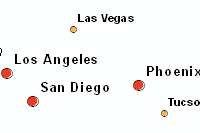

In [3]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service owner:esri*', 
                                      outside_org=True)[0]
sample_cities

Place the cities to be visited in a list, and provide a formatter that will later be used to format the list into a string.

In [4]:
stops_cities = ['San Francisco', 'San Jose', 'Los Angeles', 'San Diego',
                'Phoenix', 'El Paso', 
                'Houston', 'New Orleans', 'Orlando', 'Miami']
values = "'" + "', '".join(stops_cities) + "'"

In [5]:
stops_cities_fl = FeatureLayer(sample_cities.url + "/0")
type(stops_cities_fl)

arcgis.features.layer.FeatureLayer

With the `FeatureLayer` class object defined, make `query` calls to get back the cities as FeatureSet.

In [6]:
stops_cities_fset = stops_cities_fl.query(where="ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(values), as_df=False)
stops_cities_fset

<FeatureSet> 10 features

In [7]:
start_cities_fset = stops_cities_fl.query(where="ST='FL' AND NAME = 'Miami'", as_df=False)
start_cities_fset

<FeatureSet> 1 features

### Re-arrange the order of stops

Sometimes features in the returned resulting FeatureSet from `FeatureLayer.query()` are not in the same sequential order of the search string. For example, the starting city in `stops_cities` is "San Francisico", but in the returned FeatureSet `stops_cities_fset`, "Los Angeles" appears to be the start. 

In [8]:
print(list(map(lambda x: x.attributes['NAME'], stops_cities_fset)))

['Los Angeles', 'San Diego', 'San Francisco', 'San Jose', 'Phoenix', 'New Orleans', 'Miami', 'Orlando', 'El Paso', 'Houston']


The method `re_order_stop_cities` can be used to re-order the stops in the FeatureSet to match the original starting/ending sequence.

In [9]:
""" Used to re-order the stops to the desired order
"""
def re_order_stop_cities(fset=stops_cities_fset, start_city = "Miami", end_city = "San Francisco"):
    
    stops_cities_flist = []
    last_city = None

    for ea in fset:
        if ea.attributes['NAME'] == start_city:
            stops_cities_flist.insert(0, ea)
        elif ea.attributes['NAME'] == end_city:
            last_city = ea
        else:
            stops_cities_flist.append(ea)
    stops_cities_flist.append(last_city)
 
    return FeatureSet(stops_cities_flist)

In [10]:
re_ordered_stops_cities_fset = re_order_stop_cities()
re_ordered_stops_cities_fset

<FeatureSet> 10 features

Also we need to assign `spatialReference` to the newly sorted FeatureSet, or else, an error would be thrown at the solver as `Invalid value for parameter Stops - Details : Invalid JSON for GPFeatureRecordSetLayer or GPRecordSet datatype Failed.`

In [27]:
re_ordered_stops_cities_fset.spatial_reference = stops_cities_fset.spatial_reference

In [34]:
re_ordered_stops_cities = list(map(lambda x: x.attributes['NAME'], re_ordered_stops_cities_fset))
print(re_ordered_stops_cities)

['Miami', 'Los Angeles', 'San Diego', 'San Jose', 'Phoenix', 'New Orleans', 'Orlando', 'El Paso', 'Houston', 'San Francisco']


## Methods

The ArcGIS API for Python provides three ways to solve a routing problem, which are namely, **RouteLayer.solve**, **find_routes**, and **plan_routes**.

| Operation       |  network.analysis       | features.use_proximity |
|-----------------|-------------------------|------------------------|
| Route           |  **find_routes**        | **plan_routes**        |
| ServiceArea     |  generate_service_areas | create_drive_time_areas|
| ClosestFacility |  find_closest_facilities| find_nearest |

These three methods are defined in different modules of the arcgis package, and will make distinct REST calls in the back end. A key separation from **RouteLayer.solve** than **find_routes** and **plan_routes** is that the former is sending requests to the Network Analysis Layer on ArcGIS Online or the enterprise for ArcGIS, while the other two tools would trigger the Geoprocessing services.

In this part of guide, we will walk through the workflows of using `network.analysis.find_routes()` and `features.use_proximity.plan_routes()` in solving the same problem - designing the quickest route to travel amongst the ten cities defined in `stops_cities`, and further explore the differences in the process.

### Method 1 - Using arcgis.network.analysis.find_routes

Finding a route analysis can mean determining the quickest or shortest way to travel between locations. You might want to use the `find_routes` tool in arcgis.network.analysis module to generate driving directions to visit multiple stops or to measure the distance or travel time between locations. The tool is capable of finding routes for one or more vehicles each time it runs, so you can determine the best routes for several drivers to visit pre-assigned stops. Parameters for `find_routes` include:
 - `stops`: Required parameter. Specify two or more stops to route between;
 - `preserve_terminal_stops`: Preserve Terminal Stops (string). Optional parameter. When Reorder Stops to Find Optimal Routes is checked (or True), you have options to preserve the starting or ending stops and the tool can reorder the rest.
 - `time_of_day`: Time of Day (datetime). Optional parameter. Specifies the time and date at which the routes should begin;
 - `time_zone_for_time_of_day`: Time Zone for Time of Day (str). Optional parameter. Specifies the time zone of the Time of Day parameter.
 - set `save_output_na_layer` to True, if you want to save the output route into a new layer file.

In [31]:
%%time

start_time = int(dt.datetime.now().timestamp() * 1000)

result = network.analysis.find_routes(re_ordered_stops_cities_fset, time_of_day=start_time, 
                                      time_zone_for_time_of_day="UTC",
                                      preserve_terminal_stops="Preserve None",
                                      reorder_stops_to_find_optimal_routes=True,
                                      save_output_na_layer=True)

WARNING 030194: Data values longer than 500 characters for field [Stops:Name] are truncated.
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 1min 37s


Then, let's check if the tool has been successfully run, what are the types of each output element, and the network analysis layer URL of the output route.

In [13]:
print("Is the tool executed successfully?", result.solve_succeeded)

Is the tool executed successfully? True


The result we get from the previous operation is a tool output that contains three components - output_routes, output_stops, and output_directions.

In [18]:
type(result)

arcgis.geoprocessing._support.ToolOutput

In [14]:
result.output_routes, result.output_stops, result.output_directions

(<FeatureSet> 1 features, <FeatureSet> 10 features, <FeatureSet> 269 features)

In [15]:
result.output_network_analysis_layer.url

'https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/route_gpserver/jecc3110a24fc4c89915ab528533fde6b/scratch/_ags_gpna4a393d66a50b4c948e49c038a80fa8c9.lyr'

#### Tabularizing the response from find_routes

The `output_directions` component of the result can be read as a pandas data frame (which lists all the directions on the route).

In [16]:
""" Access the output directions
"""
df = result.output_directions.sdf
df = df[["RouteName", "ArriveTime", "DriveDistance", "ElapsedTime", "Text"]].loc[df["RouteName"] == "Miami - San Francisco"]
df.head()

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
0,Miami - San Francisco,2019-10-23 16:26:20.019000053,0.000000,0.000000,Start at Miami
1,Miami - San Francisco,2019-10-23 16:26:20.019000053,0.417397,1.993611,Go east on SW 13th St toward SW 16th Ave
2,Miami - San Francisco,2019-10-23 16:28:19.635999918,1.612950,8.661213,Turn left on SW 12th Ave (SR-933)
3,Miami - San Francisco,2019-10-23 16:36:59.308000088,0.504081,1.296284,Take the ramp on the right and go on SR-836-TO...
4,Miami - San Francisco,2019-10-23 16:38:17.085000038,8.960816,24.845049,Take the ramp on the left and go on I-95 N tow...


In [17]:
df.tail()

,RouteName,ArriveTime,DriveDistance,ElapsedTime,Text
264,Miami - San Francisco,2019-10-25 16:14:34.987999916,0.058411,0.275413,Bear right on Loma Vista Ter
265,Miami - San Francisco,2019-10-25 16:14:51.513000011,0.059725,0.346418,Make a sharp right on Upper Ter
266,Miami - San Francisco,2019-10-25 16:15:12.298000097,0.067130,0.631127,Bear left
267,Miami - San Francisco,2019-10-25 16:15:12.298000097,0.000000,0.000000,Restriction: Through Traffic Prohibited
268,Miami - San Francisco,2019-10-25 16:15:50.164999962,0.000000,0.000000,"Finish at San Francisco, on the left"


Also, from the `output_routes` component of the returned object, we can then form a summary table of the entire trip.

In [19]:
""" Access output routes
"""
df = result.output_routes.sdf
start_times = pd.to_datetime(df["StartTime"], unit="ms")
end_times = pd.to_datetime(df["EndTime"], unit="ms")
df["StartTime"] = start_times.apply(lambda x: x.strftime("%H:%M:%S"))
df["EndTime"] = end_times.apply(lambda x: x.strftime("%H:%M:%S"))
df[["Name", "StartTime", "EndTime", "StopCount", "Total_Kilometers", "Total_Minutes"]]

,Name,StartTime,EndTime,StopCount,Total_Kilometers,Total_Minutes
0,Miami - San Francisco,16:26:20,16:15:50,10,5277.045425,3049.502439


Based on the results shown above, the estimated travel distance from Miami to San Francisco is 5277.045 KM, and the estimated travel time is 3049.502 minutes (around 50.825 hours), which means that, if you start from Miami at 16:26:20 PM (EST) on Monday, for instance, you can expect to arrive at San Francisco at 16:15:50 PM (PST) of the same Wednesday.

#### Visualizing the response from find_routes

Now that we have fully mastered the itineraries of the trip, it is time to visualize the route on the map widget so target users can have a better grasp of the geographical relations between stops.

The following cell defines the styles and symbologies for the stops, and routes. In order to emphasize on the starting and ending stops, we will assign balloon icons as their symbols.

In [20]:
""" draw the route and stops with customized styles, symbologies, and popups
"""
styles = [    
    dict(selector="td", props=[("padding", "2px")]),
    dict(selector='.row_heading, .blank', props=[('display', 'none;')]),
    dict(selector='.col_heading, .blank', props=[('display', 'none;')])]

route_symbol = {
                    "type": "esriSLS",
                    "style": "esriSLSSolid",
                    "color": [128,0,128,90],
                    "width": 4
                }

stops_symbol = {"angle":0,"xoffset":2,"yoffset":8,"type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/Basic/ShinyPin.png",
                "contentType":"image/png","width":24,"height":24}

start_symbol = {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS",
                "url":"http://static.arcgis.com/images/Symbols/AtoZ/redA.png",
                "contentType":"image/png","width":15.75,"height":21.75}

end_symbol = {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS",
              "url":"http://static.arcgis.com/images/Symbols/AtoZ/greenB.png",
              "contentType":"image/png","width":15.75,"height":21.75}

popup_route = {"title": "Route", 
               "content": df.style.set_table_styles(styles).render()}
popup_stop = {"title": "Stop {}", 
              "content": df.style.set_table_styles(styles).render()}

Here, we will use the function `check_curb_approach2` to determine if the stop is the start (the departing point), a by-passing point, or the end (the arriving point) of the route.

In [21]:
def check_curb_approach2(result):
    attributes = result.attributes
    return (attributes['ArriveCurbApproach'], attributes['DepartCurbApproach'])


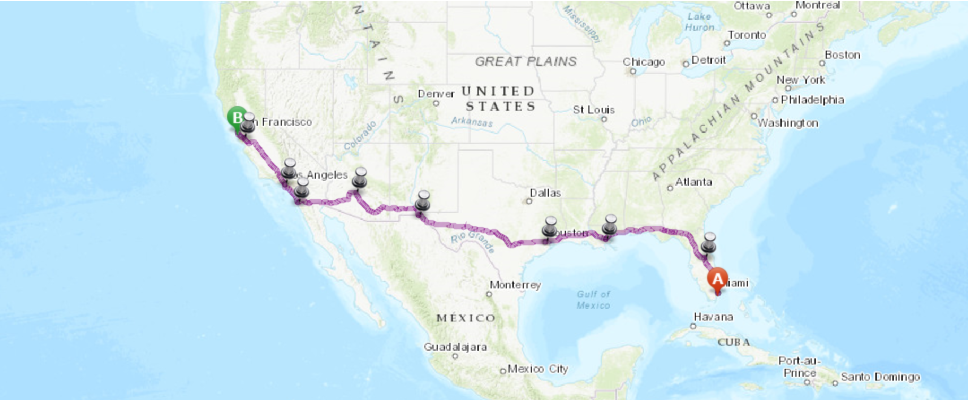

In [62]:
map1 = my_gis.map('Texas, USA', zoomlevel=4)
map1

In [42]:
""" draw the route and stops with customized styles, symbologies, and popups
"""
for route in result.output_routes:
    map1.draw(route.geometry, popup_route, route_symbol)

sequence = 1
for stop in result.output_stops:
    
    stop_bool_tuple = check_curb_approach2(stop)
    if stop_bool_tuple[0] is None:
        # starting point
        symbol = start_symbol
    elif stop_bool_tuple[1] is None:
        # ending point
        symbol = end_symbol
    else:
        # by-passing point
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop.geometry)['address']['Match_addr']
    map1.draw(stop.geometry, 
              {"title": "Stop {}".format(sequence), 
               "content": address},
              symbol)
    sequence+=1

In [43]:
#save into a web map
item_properties = {
    "title": "Miami - San Francisco (find routes)",
    "tags" : "Routing",
    "snippet": " Route from Miami to San Francisco",
    "description": "a web map of Route from Miami to San Francisco using network.RouteLayer.solve",
    "type": "Feature Collection",
    "typeKeywords": "Data, Feature Collection, Singlelayer",
    "extent" : map1.extent
}
item = map1.save(item_properties)

In [44]:
item

<Item title:"Miami - San Francisco (2)" type:Web Map owner:portaladmin>

We have been using the find_routes tool in the network.analysis module up to this point. From now on, let's use a different method - plan_routes - defined in the features.use_proximity module, to achieve a workflow driven, Feature Service to Feature Service user experience.

### Method 2 - Using arcgis.features.use_proximity.plan_routes

The plan_routes method determines how to efficiently divide tasks among a mobile workforce.

You provide the input, which includes a set of stops and the number of vehicles available to visit the stops, and the tool assigns the stops to vehicles and returns routes showing how each vehicle can reach their assigned stops in the least amount of time.

With plan_routes, mobile workforces reach more job sites in less time, which increases productivity and improves customer service. Organizations often use plan_routes to:

 - Inspect homes, restaurants, and construction sites
 - Provide repair, installation, and technical services
 - Deliver items and small packages
 - Make sales calls
 - Provide van transportation from spectators’ homes to events
 
For more information, please refer to the <a href="https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.use_proximity.html?highlight=plan_routes#arcgis.features.use_proximity.plan_routes">API help doc</a>.

#### Prepare the input parameters

Because the `stops_layer` is required to be of a Feature Layer, we need to prepare the input data in a different format.

In [22]:
re_ordered_values = "'" + "', '".join(re_ordered_stops_cities) + "'"
re_ordered_values

"'Miami', 'Los Angeles', 'San Diego', 'San Jose', 'Phoenix', 'New Orleans', 'Orlando', 'El Paso', 'Houston', 'San Francisco'"

In [23]:
stops_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(re_ordered_values)}
start_layer = {'url': sample_cities.layers[0].url, 
               'filter': "ST = 'FL' AND NAME = 'Miami'"}
end_layer = {'url': sample_cities.layers[0].url, 
             'filter': "NAME = 'San Francisco'"}

#### With output_name specified

A reference to the output Feature Layer Collection is returned with `output_name` is specified. And the returned Feature Layer includes a layer of routes showing the shortest paths to visit the stops; a layer of the stops assigned to routes, as well as any stops that couldn’t be reached due to the given parameter settings; and a layer of directions containing the travel itinerary for each route.

In [25]:
%%time

""" using https://analysis7.arcgis.com/arcgis/rest/services/tasks/GPServer/PlanRoutes/submitJob
"""
result1 = use_proximity.plan_routes(stops_layer=stops_layer, route_count=1, 
                                    max_stops_per_route=10, route_start_time=start_time,
                                    start_layer_route_id_field = "FID",
                                    start_layer=start_layer, 
                                    end_layer=end_layer,
                                    return_to_start=False,
                                    context={'outSR': {"wkid": 4326}},
                                    output_name="Plan Route from Miami to San Francisco",
                                    gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 2min 5s


In [26]:
result1

<Item title:"Plan Route from Miami to San Francisco" type:Feature Layer Collection owner:arcgis_python>

In [27]:
route_sublayer = FeatureLayer.fromitem(result1, layer_id=1)
route_sublayer.url

'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/Plan Route from Miami to San Francisco/FeatureServer/1'

In [28]:
route_sublayer.query(where='1=1', as_df=True)

,EndTime,EndTimeUTC,OBJECTID,RouteLayerItemID,RouteLayerItemURL,RouteName,SHAPE,StartTime,StartTimeUTC,StopCount,TotalStopServiceTime,TotalTime,TotalTravelTime,Total_Kilometers,Total_Miles
0,2019-10-25 20:46:14,2019-10-26 03:46:14,1,None,None,Miami - San Francisco - Route1,"{'paths': [[[-8930153.5818, 2969499.7754], [-8...",2019-10-23 20:26:20,2019-10-24 00:26:20,10,0,3079.901315,3079.901315,5282.739,3282.549989


From this summary table, we can tell the estimated travel distance from Miami to San Francisco is 5282.739 KM, and the estimated travel time is 3079.901 minutes (around 51.332 hours).

In [29]:
map2a = my_gis.map('Texas, USA', zoomlevel=4)
map2a

MapView(layout=Layout(height='400px', width='100%'), zoom=4.0)

In [31]:
map2a.add_layer(result1)

We have seen how a Feature Service (input) to Feature Service (output) workflow is like from previous operation, now let's look at a different approach - when the output name is not specified in the arguments.

#### Without output_name specified

A dict object is returned without `output_name` being specified:

In [33]:
%%time

""" using https://analysis7.arcgis.com/arcgis/rest/services/tasks/GPServer/PlanRoutes/submitJob
"""
result1 = use_proximity.plan_routes(stops_layer=stops_layer, route_count=1, 
                                   max_stops_per_route=10, route_start_time=start_time,
                                   start_layer_route_id_field = "FID",
                                   start_layer=start_layer, 
                                   end_layer=end_layer,
                                   return_to_start=False,
                                   context={'outSR': {"wkid": 4326}},
                                   gis=my_gis)

Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


Wall time: 1min 37s


And the returned dictionary contains two components - routes_layer and assigned_stops_layer.

In [34]:
result1.keys()

dict_keys(['routes_layer', 'assigned_stops_layer'])

We can create a pandas data frame out of the `routes_layer` component to summarize the records. In the cell below, we can see for the route "Miami to San Francisco", 10 stops are made, with the total time and distance specified.

In [35]:
df = pd.DataFrame.from_records([i['attributes'] for i in 
                                result1['routes_layer'].layer.featureSet.features])
df[['RouteName', 'StopCount', 'TotalTime', 'Total_Kilometers']]

,RouteName,StopCount,TotalTime,Total_Kilometers
0,Miami - San Francisco - Route1,10,3079.901315,5282.739


For the stops to be made on the route, we take advantage of the `assigned_stops_layer`, and convert it to a pandas dataframe object.

In [36]:
df2 = pd.DataFrame.from_records([i['attributes'] for i in 
                                result1['assigned_stops_layer'].layer.featureSet.features])

df2[['OID', 'NAME', 'ST', 'PLACEFIPS', 'RouteName', 'StopType', 'Sequence', 'ArriveTime', 'FromPrevDistanceKilometers']]

,OID,NAME,ST,PLACEFIPS,RouteName,StopType,Sequence,ArriveTime,FromPrevDistanceKilometers
0,1,None,None,None,Miami - San Francisco - Route1,Route start,1,1571862380000,0.000000
1,2,Miami,FL,1245000,Miami - San Francisco - Route1,Stop,2,1571862380000,0.000000
2,3,Orlando,FL,1253000,Miami - San Francisco - Route1,Stop,3,1571876628541,386.309025
3,4,New Orleans,LA,2255000,Miami - San Francisco - Route1,Stop,4,1571906734316,1028.402013
4,5,Houston,TX,4835000,Miami - San Francisco - Route1,Stop,5,1571926745819,560.581917
5,6,El Paso,TX,4824000,Miami - San Francisco - Route1,Stop,6,1571962109419,1203.096420
6,7,Phoenix,AZ,0455000,Miami - San Francisco - Route1,Stop,7,1571981624001,691.807799
7,8,San Diego,CA,0666000,Miami - San Francisco - Route1,Stop,8,1572001931698,570.860072
8,9,Los Angeles,CA,0644000,Miami - San Francisco - Route1,Stop,9,1572011490717,206.458328
9,10,San Jose,CA,0668000,Miami - San Francisco - Route1,Stop,10,1572032077960,547.931169


In order to show the arrival time and better organize the columns, try the cell below to do a little parsing:

In [37]:
my_columns = ['OID', 'NAME', 'ST', 'PLACEFIPS', 'RouteName', 'StopType', 'Sequence', 'ArriveTime', 'FromPrevDistanceKilometers']
length = len(result1['assigned_stops_layer'].layer.featureSet.features)
frames = []
my_df = None

for i in range(length):
    my_list = [result1['assigned_stops_layer'].layer.featureSet.features[i]['attributes'][x] for x in my_columns]
    df = pd.DataFrame(np.array(my_list).reshape(1,9), columns = my_columns)

    end_times = pd.to_datetime(my_list[7], unit="ms")
    df["ArriveTime"] = end_times.strftime("%H:%M:%S")
    df['Sequence'] = int(df['Sequence'])
    if my_df is None:
        my_df=df
    else:
        my_df = my_df.append(df, ignore_index=True, sort=True)

my_df.sort_values('Sequence', inplace=True, ascending=True)
my_df.head(10)

,ArriveTime,FromPrevDistanceKilometers,NAME,OID,PLACEFIPS,RouteName,ST,Sequence,StopType
0,20:26:20,0,None,1,None,Miami - San Francisco - Route1,None,1,Route start
1,20:26:20,0,Miami,2,1245000,Miami - San Francisco - Route1,FL,2,Stop
2,00:23:48,386.30902496820005,Orlando,3,1253000,Miami - San Francisco - Route1,FL,3,Stop
3,08:45:34,1028.4020133934848,New Orleans,4,2255000,Miami - San Francisco - Route1,LA,4,Stop
4,14:19:05,560.5819165389727,Houston,5,4835000,Miami - San Francisco - Route1,TX,5,Stop
5,00:08:29,1203.0964202417288,El Paso,6,4824000,Miami - San Francisco - Route1,TX,6,Stop
6,05:33:44,691.8077993167915,Phoenix,7,0455000,Miami - San Francisco - Route1,AZ,7,Stop
7,11:12:11,570.8600722182784,San Diego,8,0666000,Miami - San Francisco - Route1,CA,8,Stop
8,13:51:30,206.4583281847757,Los Angeles,9,0644000,Miami - San Francisco - Route1,CA,9,Stop
9,19:34:37,547.9311694929524,San Jose,10,0668000,Miami - San Francisco - Route1,CA,10,Stop


Note that the starting time `20:26:20` as listed is the Coordinated Universal Time (UTC), which is the same as the starting time for solution 1 `16:26:20` Easter Time (ET). And the arrive time as shown here needs to be converted to local time of San Jose, which would be `16:34:37` Pacific Time (PT).


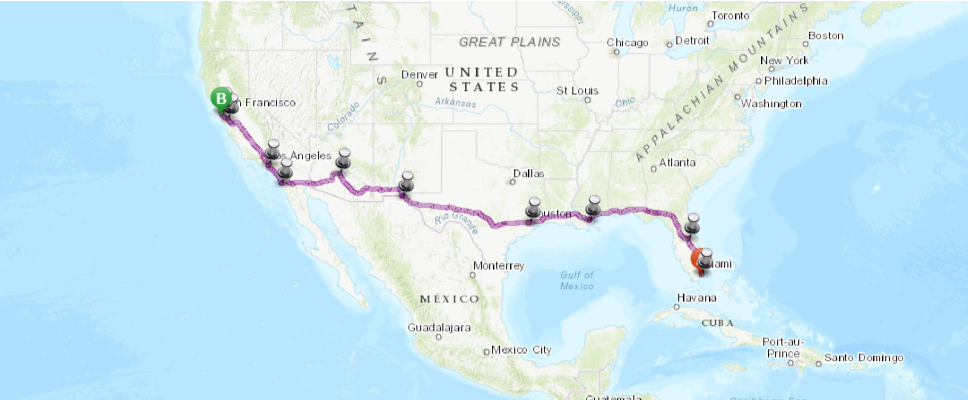

In [61]:
map2 = gis.map('Texas, USA', zoomlevel=4)
map2

In [58]:
""" draw the route and stops with customized styles, symbologies, and popups
"""
for route in result1['routes_layer'].query():
    map2.draw(route.geometry, popup_route, route_symbol)

sequence = 1
for stop in result1['assigned_stops_layer'].query():
    if stop.attributes['StopType']=="Route start":
        # starting point
        symbol = start_symbol
    elif stop.attributes['StopType']=="Route end":
        # ending point
        symbol = end_symbol
    else:
        # by-passing point
        symbol = stops_symbol
        
    address = geocoding.reverse_geocode(stop.geometry)['address']['Match_addr']
    print(address)
    map2.draw(stop.geometry, 
              {"title": "Stop {}".format(sequence), 
               "content": address},
              symbol)
    sequence+=1

1620 SW 13th St, Miami, Florida, 33145
1620 SW 13th St, Miami, Florida, 33145
East-West Expy, Orlando, Florida, 32801
302-330 Loyola Ave, New Orleans, Louisiana, 70112
Starbucks
Anny Fashions
124 S Central Ave, Phoenix, Arizona, 85004
Pershing Dr, San Diego, California, 92101
1523 Cambria St, Los Angeles, California, 90017
61 N 6th St, San Jose, California, 95112
550-560 Buena Vista Ave W, San Francisco, California, 94117
550-560 Buena Vista Ave W, San Francisco, California, 94117


From the cell output above, we can see that though we are routing from cities to cities, the real logic under the solver is to pick a specific address in the city before the route is computed.

In [59]:
item_properties["title"] = "Miami - San Francisco (plan routes)"
item_properties["extent"] = map2.extent
item = map2.save(item_properties)

In [60]:
item

<Item title:"Miami - San Francisco (3)" type:Web Map owner:portaladmin>

In the last section of this guide, we have adopted a different method - `arcgis.features.use_proximity.plan_routes` - in solving the routing problem between ten cities. In doing so, we also explored the two scenarios with output_name specified (which forms a Feature Service to Feature Service user experience), and a more traditional compute/parse/draw approach when output_name is not present.

## What's next?

Part 2 has introduced `arcgis.network.analysis.find_routes` and `arcgis.features.use_proximity.plan_routes` as solvers to the routing problem, how to prepare for data required as input arguments by these solvers, and ways to tabularize, map, and the save the output from solvers.

Now that we have mastered techniques in solving route finding problems, let's proceed to the next topic - generate service areas with network.analysis and features.use_proximity modules in <a href="guide_to_network_analysis_part3.ipynb">Part 3</a>.

## References

[1] "Tutorial: Create routes", https://pro.arcgis.com/en/pro-app/help/analysis/networks/route-tutorial.htm, accessed August 10, 2019

[2] "Route analysis layer", https://pro.arcgis.com/en/pro-app/help/analysis/networks/route-analysis-layer.htm, accessed on September 20, 2019

[3] "Find Routes", http://desktop.arcgis.com/en/arcmap/10.3/tools/network-analyst-toolbox/find-routes.htm, accessed on September 5, 2019